
# 🎼 AI Music Composer (Final-Year Project) — Notebook
End‑to‑end pipeline: dataset → preprocessing → model → generation → evaluation.

> Run cells top‑to‑bottom. Start with a **small subset** to verify the flow, then scale up.


## 1) Setup — install and imports

In [2]:

# If you're on Colab, you can mount Drive to access files
# from google.colab import drive; drive.mount('/content/drive')

# Minimal, idempotent installs
import sys, subprocess, pkgutil
def pip_install(package):
    try:
        __import__(package)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

for pkg in ["music21", "pretty_midi", "numpy", "matplotlib", "tensorflow", "soundfile"]:
    pip_install(pkg)

import os, glob, random, json, math
import numpy as np
import matplotlib.pyplot as plt
import music21 as m21
import pretty_midi as pm
import soundfile as sf
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers, models

print("TensorFlow:", tf.__version__)
print("Setup complete.")


TensorFlow: 2.18.0
Setup complete.


## 2) Point to your MIDI dataset

In [3]:

# 👉 Set this to your dataset root. Supports nested subfolders (e.g., data/classical/*.mid)
DATA_DIR = "C:/Users/pavan/Downloads/project/data"  # e.g., "/content/drive/MyDrive/ai-music-composer/data"

midi_files = [str(p) for p in Path(DATA_DIR).rglob("*.mid")] + [str(p) for p in Path(DATA_DIR).rglob("*.midi")]
print(f"Found {len(midi_files)} MIDI files. Example:", midi_files[:5])


Found 1398 MIDI files. Example: ['C:\\Users\\pavan\\Downloads\\project\\data\\classical\\albeniz\\alb_esp1.mid', 'C:\\Users\\pavan\\Downloads\\project\\data\\classical\\albeniz\\alb_esp2.mid', 'C:\\Users\\pavan\\Downloads\\project\\data\\classical\\albeniz\\alb_esp3.mid', 'C:\\Users\\pavan\\Downloads\\project\\data\\classical\\albeniz\\alb_esp4.mid', 'C:\\Users\\pavan\\Downloads\\project\\data\\classical\\albeniz\\alb_esp5.mid']


### (Optional) Use a small subset first (smoke test)

In [4]:

USE_SUBSET = True
SUBSET_N = 50  # start small

if USE_SUBSET and len(midi_files) > SUBSET_N:
    random.seed(42)
    midi_files = random.sample(midi_files, SUBSET_N)
print(f"Using {len(midi_files)} files for this run.")


Using 50 files for this run.


## 3) Preprocessing — MIDI → note/chord tokens

In [5]:

def extract_notes_from_midi(file_path):
    # Extract a simple token stream from a MIDI: note names and chord pitch classes.
    tokens = []
    try:
        score = m21.converter.parse(file_path)
        notes_to_parse = score.flat.notes  # includes notes and chords
        for el in notes_to_parse:
            if isinstance(el, m21.note.Note):
                tokens.append(str(el.pitch))  # e.g., 'C4'
            elif isinstance(el, m21.chord.Chord):
                tokens.append('.'.join(str(n) for n in el.normalOrder))  # e.g., '0.4.7'
    except Exception as e:
        print(f"[WARN] Failed {file_path}: {e}")
    return tokens

all_tokens = []
file_lengths = []
for fp in midi_files:
    toks = extract_notes_from_midi(fp)
    if len(toks) >= 64:
        all_tokens.extend(toks)
        file_lengths.append(len(toks))

print(f"Collected {len(all_tokens)} tokens from {len(file_lengths)} files.")
print("Avg tokens per file:", np.mean(file_lengths) if file_lengths else 0)


c:\Users\pavan\AppData\Local\Programs\Python\Python311\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Collected 72467 tokens from 47 files.
Avg tokens per file: 1541.8510638297873


## 4) Build vocabulary and training sequences

In [6]:

unique_tokens = sorted(set(all_tokens))
token_to_int = {t:i for i,t in enumerate(unique_tokens)}
int_to_token = {i:t for t,i in token_to_int.items()}
vocab_size = len(unique_tokens)
print("Vocab size:", vocab_size)

SEQ_LEN = 50
inputs, targets = [], []

for i in range(len(all_tokens) - SEQ_LEN):
    seq_in = all_tokens[i:i+SEQ_LEN]
    seq_out = all_tokens[i+SEQ_LEN]
    inputs.append([token_to_int[t] for t in seq_in])
    targets.append(token_to_int[seq_out])

import numpy as np
X = np.array(inputs, dtype=np.int32)
import tensorflow as tf
y = tf.keras.utils.to_categorical(np.array(targets, dtype=np.int32), num_classes=vocab_size)
print("X shape:", X.shape, "y shape:", y.shape)


Vocab size: 635
X shape: (72417, 50) y shape: (72417, 635)


## 5) Model — LSTM (simple and effective)

In [8]:

EMBED_DIM = 128
HIDDEN = 256

model = models.Sequential([
    layers.Embedding(vocab_size, EMBED_DIM, input_length=SEQ_LEN),
    layers.LSTM(HIDDEN, return_sequences=True),
    layers.LSTM(HIDDEN),
    layers.Dense(HIDDEN, activation="relu"),
    layers.Dense(vocab_size, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 6) Train

In [9]:

EPOCHS = 20
BATCH_SIZE = 64

history = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)


Epoch 1/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 223s 214ms/step - loss: 5.2085 - val_loss: 4.5975
Epoch 2/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 205s 202ms/step - loss: 4.5516 - val_loss: 4.2769
Epoch 3/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 200s 196ms/step - loss: 4.1482 - val_loss: 4.1211
Epoch 4/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 216s 212ms/step - loss: 3.8807 - val_loss: 4.0791
Epoch 5/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 221s 217ms/step - loss: 3.6731 - val_loss: 4.0902
Epoch 6/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 210s 206ms/step - loss: 3.4860 - val_loss: 4.1349
Epoch 7/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 213s 209ms/step - loss: 3.3177 - val_loss: 4.1758
Epoch 8/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 216s 212ms/step - loss: 3.1686 - val_loss: 4.2455
Epoch 9/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 242s 237ms/step - loss: 3.0154 - val_loss: 4.2936
Epoch 10/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 250s 245ms/step - loss: 2.8775 - val_loss: 4.3305
Epoch 11/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 218s 214ms/step - loss: 2.7654 - val

### Plot training curves

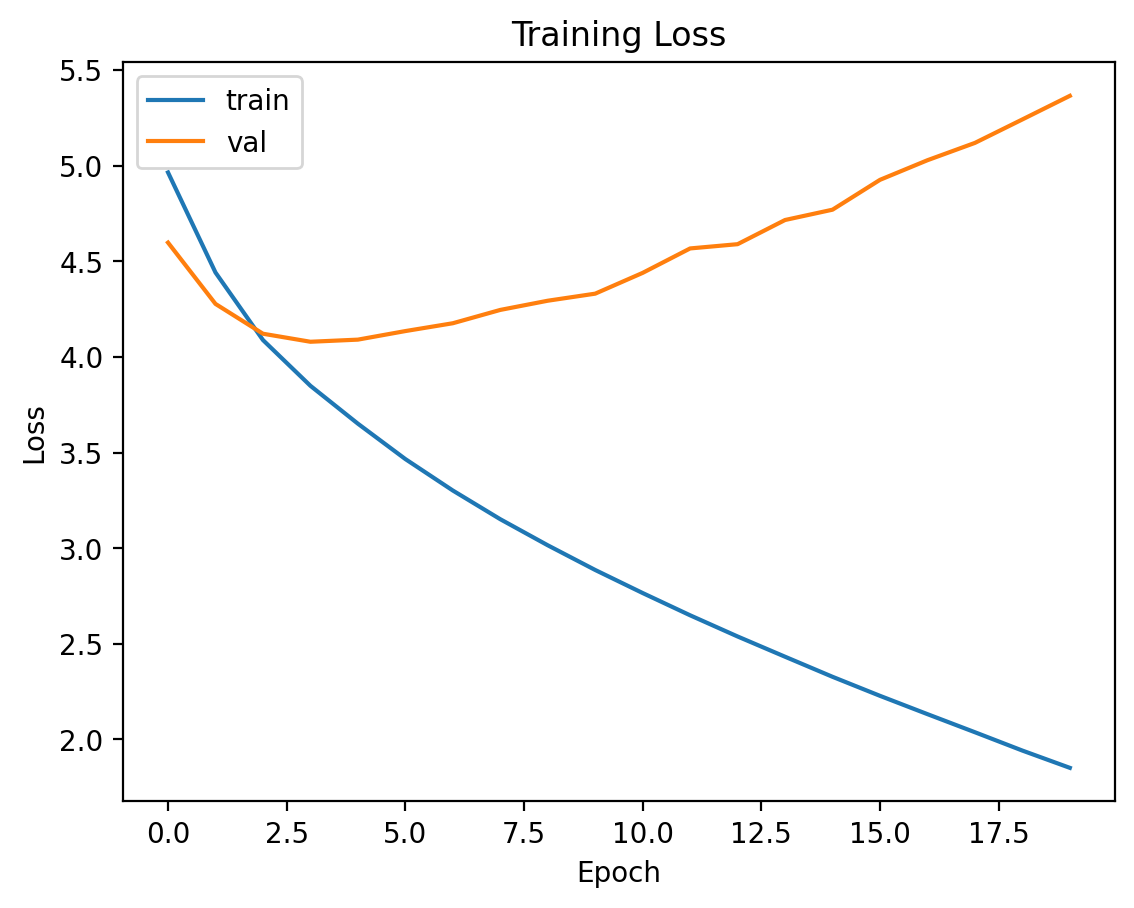

In [10]:

import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history["loss"], label="train")
if "val_loss" in history.history:
    plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.legend(); plt.show()


## 7) Generate new music (tokens → MIDI)

In [11]:

import numpy as np

def sample_from_probs(probs, temperature=1.0):
    probs = np.asarray(probs).astype("float64")
    if temperature <= 0:
        return int(np.argmax(probs))
    logits = np.log(probs + 1e-12) / temperature
    exp = np.exp(logits - np.max(logits))
    probs = exp / np.sum(exp)
    return int(np.random.choice(len(probs), p=probs))

def generate_sequence(model, seed_tokens, length=200, temperature=1.0):
    seq = seed_tokens.copy()
    for _ in range(length):
        x = np.array([seq[-SEQ_LEN:]], dtype=np.int32)
        preds = model.predict(x, verbose=0)[0]
        idx = sample_from_probs(preds, temperature=temperature)
        seq.append(idx)
    return seq

seed = [token_to_int[t] for t in all_tokens[:SEQ_LEN]]
gen_ints = generate_sequence(model, seed, length=300, temperature=0.9)
gen_tokens = [int_to_token[i] for i in gen_ints]
print("Generated tokens (preview):", gen_tokens[:30], "...")


Generated tokens (preview): ['E4', 'E3', 'F4', 'F3', 'B-1', '10.2.5', 'D5', 'D4', '10.2', 'E4', 'E3', 'F4', 'F3', 'F2', 'C5', 'C4', '10.2', 'E4', 'E3', '10.2.5', 'F4', 'F3', 'B-1', '10.2.5', 'B-4', 'B-3', 'E4', 'E3', 'F4', 'F3'] ...


### Convert generated tokens to MIDI and save

In [12]:

def tokens_to_midi(tokens, out_path="outputs/midi/generated_music.mid", step=0.5):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    output_notes = []
    offset = 0.0
    for pattern in tokens:
        try:
            if ("." in pattern) or pattern.isdigit():
                chord_notes = pattern.split(".")
                chord = m21.chord.Chord(chord_notes)
                chord.offset = offset
                output_notes.append(chord)
            else:
                n = m21.note.Note(pattern)
                n.offset = offset
                output_notes.append(n)
        except Exception:
            continue
        offset += step
    stream = m21.stream.Stream(output_notes)
    stream.write("midi", fp=out_path)
    return out_path

midi_out = tokens_to_midi(gen_tokens, out_path="outputs/midi/generated_music.mid")
print("Saved MIDI:", midi_out)


Saved MIDI: outputs/midi/generated_music.mid


### (Optional) Render MIDI to WAV (basic synth via pretty_midi)

In [13]:

def midi_to_wav_sine(midi_path, wav_path="outputs/wav/generated_music.wav", fs=44100):
    os.makedirs(os.path.dirname(wav_path), exist_ok=True)
    midi = pm.PrettyMIDI(midi_path)
    audio = midi.synthesize(fs=fs)
    sf.write(wav_path, audio, fs)
    return wav_path

wav_out = midi_to_wav_sine(midi_out, wav_path="outputs/wav/generated_music.wav")
print("Saved WAV:", wav_out)


Saved WAV: outputs/wav/generated_music.wav


## 8) Evaluation — simple diagnostics

Generated notes count: 228
Top 12 notes: [('G4', 21), ('B-1', 17), ('C2', 14), ('E-3', 13), ('D4', 12), ('F3', 11), ('F1', 11), ('G3', 10), ('F4', 9), ('F2', 9), ('B-3', 8), ('B-4', 7)]


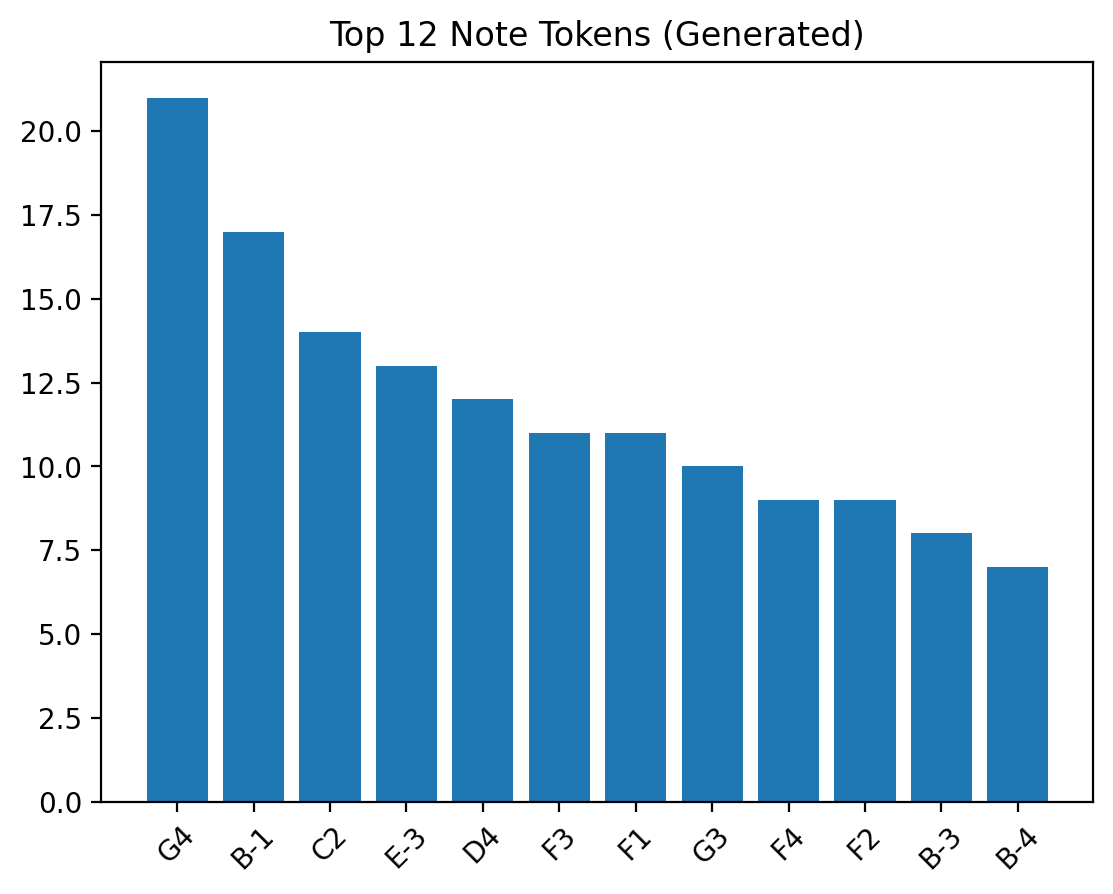

In [14]:

from collections import Counter
def token_is_note(t): 
    return not (("." in t) or t.isdigit())

gen_notes = [t for t in gen_tokens if token_is_note(t)]
print("Generated notes count:", len(gen_notes))

cnt = Counter(gen_notes)
most_common = cnt.most_common(12)
print("Top 12 notes:", most_common)

if most_common:
    labels, values = zip(*most_common)
    import matplotlib.pyplot as plt
    plt.figure()
    plt.bar(labels, values)
    plt.title("Top 12 Note Tokens (Generated)")
    plt.xticks(rotation=45)
    plt.show()


## 9) Save artifacts (vocab, model)

In [18]:

os.makedirs("models", exist_ok=True)
with open("models/vocab.json", "w") as f:
    json.dump({"token_to_int": token_to_int, "int_to_token": int_to_token}, f)

model.save("models/lstm_note_model.keras")
print("Saved vocab to models/vocab.json and model to models/lstm_note_model.keras")


Saved vocab to models/vocab.json and model to models/lstm_note_model.keras


In [22]:

# ✅ Save note mappings for inference in app.py
import pickle

with open("note_mappings.pkl", "wb") as f:
    pickle.dump((unique_tokens, token_to_int), f)

print("✅ Model and mappings saved successfully!")


✅ Model and mappings saved successfully!
